In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pystan
import corner

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [12]:
model = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters{
    real mu;
    real<lower=0.> sigma;
    real<lower=0., upper=1.> Q;
    real<lower=1.> sigo;
    real Mtrue_std[N];
}
transformed parameters{
    real Mtrue[N];
    
    for (n in 1:N)
        Mtrue[n] = mu + sigma * Mtrue_std[n];
}
model{
    mu ~ normal(-1.7, 1.0);
    sigma ~ normal(0.0, 1.0);
    sigo ~ normal(3.0, 1.0);
    Q ~ normal(.5, 0.3);

    Mobs ~ normal(Mtrue, Munc);
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(Mtrue_std[n] | 0, 1),
                    normal_lpdf(Mtrue_std[n] | 0, sigo));
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_050d9b36c801c8b759ef05996a7b366c NOW.


/home/davies/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


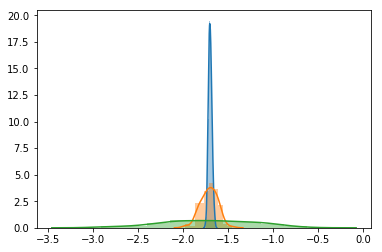

In [28]:
npts = 200
rmu = -1.7
rsig = .02
runc = .3 #fractional uncertainty
rQ = 0.5
rsigo = 5.0 * rsig

oMtrue = np.random.randn(int(npts*rQ))*rsig + rmu
iMtrue = np.random.randn(int(npts*(1.0-rQ)))*rsigo + rmu
Mtrue = np.append(oMtrue, iMtrue)
Munc = np.abs(Mtrue*runc)
Mobs = Mtrue + np.random.randn(npts)*Munc

sns.distplot(oMtrue,label='true')
sns.distplot(iMtrue,label='true')
sns.distplot(Mobs, label='obs')
plt.show()

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/davies/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


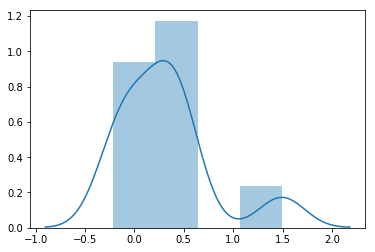

In [29]:
nloops = 10
mus = np.zeros(nloops)
muer = np.zeros(nloops)
for idx in range(nloops):
    oMtrue = np.random.randn(int(npts*rQ))*rsig + rmu
    iMtrue = np.random.randn(int(npts*(1.0-rQ)))*rsigo + rmu
    Mtrue = np.append(oMtrue, iMtrue)
    Munc = np.abs(Mtrue*runc)
    Mobs = Mtrue + np.random.randn(npts)*Munc
    
    data = {'N': npts,
           'Mobs':Mobs,
           'Munc':Munc}
    init = {'mu':rmu,
           'sigma':rsig,
            'sigo':rsigo/rsig,
            'Q': rQ,
           'Mtrue_std': np.zeros(npts)}
    fit = sm.sampling(data=data, iter=4000, chains=2, init=[init, init])
    mus[idx] = np.median(fit['mu'])
    muer[idx] = np.std(fit['mu'])
sns.distplot((mus - rmu) / muer)

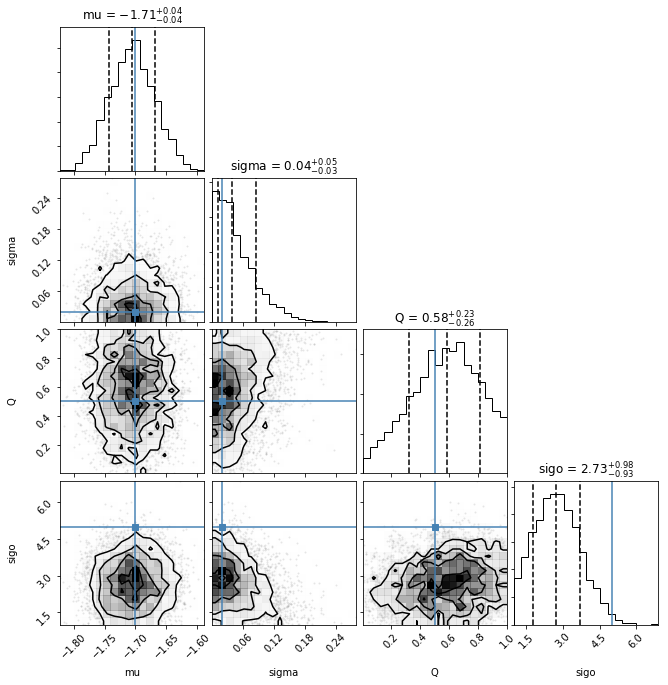

In [30]:
import corner
chain = np.array([fit['mu'],fit['sigma'], fit['Q'], fit['sigo']]).T
truths=[rmu, rsig, rQ, rsigo/rsig]
corner.corner(chain,labels=['mu','sigma','Q','sigo'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [31]:
print(np.std((mus - rmu) / muer))

0.46333780189572876


In [32]:
print(fit)

Inference for Stan model: anon_model_050d9b36c801c8b759ef05996a7b366c.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu              -1.71  5.8e-4   0.04  -1.78  -1.73  -1.71  -1.68  -1.63   4000    1.0
sigma            0.05  2.5e-3   0.04 1.4e-3   0.02   0.04   0.07   0.15    251   1.01
Q                0.57    0.02   0.23    0.1    0.4   0.58   0.74   0.96    128   1.01
sigo             2.78    0.08   0.92   1.21   2.08   2.73    3.4   4.67    147   1.02
Mtrue_std[0]     0.29    0.03   1.95  -3.81  -0.66    0.2   1.13   4.58   4000    1.0
Mtrue_std[1]     0.08    0.03   2.02  -4.08  -0.89   0.04   0.96   4.58   4000    1.0
Mtrue_std[2]     0.17    0.03   2.08  -4.27  -0.81   0.12   1.08   4.91   4000    1.0
Mtrue_std[3]    -0.04    0.03   1.93  -4.22  -0.96  -0.04   0.89   4.27   4000    1.0
Mtrue_std[4]     0.04    0.03   1.99 